In [7]:
import ants
import os
import sys
import argparse
import numpy as np
import torch
import pandas as pd
import nibabel as nib    
from pathlib import Path
from surface_distance import metrics
from tqdm import tqdm
import torch.nn as nn
import ants
import json

In [5]:
def pred_invert_resample(path_to_pred, path_to_orig, path_to_resampled):
    # path_to_pred = *npz, path_to_orig = *1_reg, path_to_resampled = *4a_resample
    # *.npz archives sometimes can be recognised wrong, if extracted and saved back at the same time
#     data = np.load(path_to_pred, allow_pickle=True)['arr_0']
    # schw
    if np.shape(data)[0] == 1:
        data = data.transpose(0,3,2,1).astype('float32')
        old_orig = ants.image_read(path_to_resampled)
        new_orig = ants.image_read(path_to_orig)
        old_like = old_orig.new_image_like(data[0])
        new_img = ants.resample_image(old_like, new_orig.spacing, False, 0)
        output_file = new_img.numpy().astype('float16')
    
    # gbm and lgg
    elif np.shape(data)[0] > 1:
        data = data.transpose(0,3,2,1).astype('float32')

        old_orig_ct1 = ants.image_read(path_to_resampled)
        new_orig_ct1 = ants.image_read(path_to_orig)

        old_like_ch_0 = old_orig_ct1.new_image_like(data[0])
        old_like_ch_1 = old_orig_ct1.new_image_like(data[1])
        old_like_ch_2 = old_orig_ct1.new_image_like(data[2])

        new_img_0 = ants.resample_image(old_like_ch_0, new_orig_ct1, False, 0)
        new_img_1 = ants.resample_image(old_like_ch_1, new_orig_ct1, False, 0)
        new_img_2 = ants.resample_image(old_like_ch_2, new_orig_ct1, False, 0)

        new_img_shape =  new_img_2.numpy().shape

        new_array = np.zeros(tuple([3] + list(new_img_shape)), dtype='float16')
        new_array[0] = new_img_0.numpy()
        new_array[1] = new_img_1.numpy()
        new_array[2] = new_img_2.numpy()
        output_file = new_array.transpose(0,3,2,1).astype('float16')
    return (output_file)

def pred_invert_resample_1cl(data, path_to_orig, path_to_resampled):
    # path_to_pred = *npz, path_to_orig = *1_reg, path_to_resampled = *4a_resample
    # *.npz archives sometimes can be recognised wrong, if extracted and saved back at the same time
#     data = np.load(path_to_pred, allow_pickle=True)['arr_0']
    # schw
        data = data.transpose(0,3,2,1).astype('float32')
        old_orig = ants.image_read(path_to_resampled)
        new_orig = ants.image_read(path_to_orig)
        old_like = old_orig.new_image_like(data[0])
        new_img = ants.resample_image(old_like, new_orig.spacing, False, 0)
        output_file = new_img.numpy().astype('float16')
        return (output_file)
    
def pred_invert_resample_classes(data, path_to_orig, path_to_resampled):

    # gbm and lgg
        data = data.transpose(0,3,2,1).astype('float32')

        old_orig_ct1 = ants.image_read(path_to_resampled)
        new_orig_ct1 = ants.image_read(path_to_orig)

        old_like_ch_0 = old_orig_ct1.new_image_like(data[0])
        old_like_ch_1 = old_orig_ct1.new_image_like(data[1])
        old_like_ch_2 = old_orig_ct1.new_image_like(data[2])

        new_img_0 = ants.resample_image(old_like_ch_0, new_orig_ct1, False, 0)
        new_img_1 = ants.resample_image(old_like_ch_1, new_orig_ct1, False, 0)
        new_img_2 = ants.resample_image(old_like_ch_2, new_orig_ct1, False, 0)

        new_img_shape =  new_img_2.numpy().shape

        new_array = np.zeros(tuple([3] + list(new_img_shape)), dtype='float16')
        new_array[0] = new_img_0.numpy()
        new_array[1] = new_img_1.numpy()
        new_array[2] = new_img_2.numpy()
        output_file = new_array.transpose(0,3,2,1).astype('float16')
        return (output_file)

(512, 512, 120)
(512, 512, 120)
[0 1]


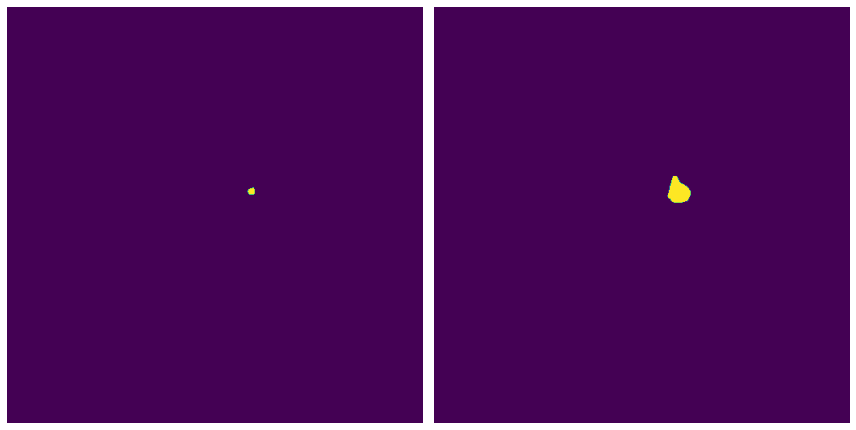

0.08575286968264687
0.01606141356613003


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from glob import glob
#  VS-SEG-002_seg.nii.gz
sub = 'VS-SEG-004'
n, z = 1, 80
for i in range(n):
    pred_sub = f'/results/schw_infer/schw_4a_resamp/predictions_best_epoch=88-dice_mean=89_45_task=39_fold=0_tta/{sub}.npy.npz'
    orig_folder = f'/data_anvar/public_datasets/preproc_study/schw/orig/{sub}/T1_SEG.nii.gz'
    resample_folder = f'/data_anvar/public_datasets/preproc_study/schw/4a_resamp/{sub}/T1_SEG.nii.gz'
    reg_1 = f'/data_anvar/public_datasets/preproc_study/schw/1_reg/{sub}/T1_SEG.nii.gz'
    targets = ants.image_read(f'/data/private_data/schw/schw_1_reg/labels/{sub}_seg.nii.gz')
    targets = ants.reorient_image2(targets, orientation = 'LAI').numpy().astype('int')
    print(targets.shape)
    data = np.load(pred_sub, allow_pickle=True)['arr_0']
    prediction = pred_invert_resample_1cl(data, reg_1, resample_folder)
    prediction = np.round(prediction, 0).astype('int')
    print(prediction.shape), print(np.unique(prediction))
   
    z = np.argsort(targets.sum(axis=(0,1)))[-1:]
    
    imgs = [prediction[:, :, z]]  + [targets[:,:,z]] 
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))
    for i in range(2):
        ax[i].imshow(imgs[i]);
        ax[i].axis('off')  
    plt.tight_layout()            
    plt.show()
    
print(metrics.compute_dice_coefficient((targets==1), (prediction==1)))
distances = metrics.compute_surface_distances((targets==1), (prediction==1), [1,1,1])
print(metrics.compute_surface_dice_at_tolerance(distances,1))

In [4]:
!cd /results/schw_infer/schw_4a_resamp && ls

 metrics_epoch_87-dice_89_19_task_39_fold_2
 metrics_epoch_88-dice_89_45_task_39_fold_0
'predictions_best_epoch=85-dice_mean=90_92_task=39_fold=1_tta'
'predictions_best_epoch=87-dice_mean=89_19_task=39_fold=2_tta'
'predictions_best_epoch=88-dice_mean=89_45_task=39_fold=0_tta'


In [14]:
met = np.load(f'/data/private_data/schw/39_3d/{sub}_meta.npy')
print(met[2]), print(met[3])

[180 210 210]
[180 210 210]


(None, None)

In [15]:
met

array([[  0,   0,   0],
       [180, 210, 210],
       [180, 210, 210],
       [180, 210, 210]])

(3, 210, 210, 180)
(1, 210, 210, 180)
(1, 210, 210, 180)
[0 1]
[54]
[[  0   0   0]
 [180 210 210]
 [180 210 210]
 [180 210 210]]


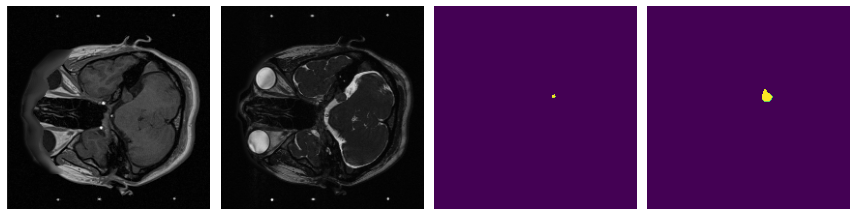

0.16487455197132617
0.17254846241760763


In [34]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from glob import glob
#  VS-SEG-002_seg.nii.gz
sub = 'VS-SEG-004'
n, z = 1, 80
for i in range(n):
    pred_sub = f'/results/schw_infer/schw_4a_resamp/predictions_best_epoch=88-dice_mean=89_45_task=39_fold=0_tta/{sub}.npy.npz'
#     orig_folder = f'/data_anvar/public_datasets/preproc_study/schw/orig/{sub}/T1_SEG.nii.gz'
#     resample_folder = f'/data_anvar/public_datasets/preproc_study/schw/4a_resamp/{sub}/T1_SEG.nii.gz'
#     reg_1 = f'/data_anvar/public_datasets/preproc_study/schw/1_reg/{sub}/T1_SEG.nii.gz'
#     targets = ants.image_read(f'/data/private_data/schw/39_3d/labels/{sub}_seg.nii.gz')
#     targets = ants.reorient_image2(targets, orientation = 'LAI').numpy().astype('int')
    img = np.load(f'/data/private_data/schw/39_3d/{sub}_x.npy').transpose(0,3,2,1)
    print(img.shape)
    targets = np.load(f'/data/private_data/schw/39_3d/{sub}_y.npy').transpose(0,3,2,1)
    print(targets.shape)
    data = np.load(pred_sub, allow_pickle=True)['arr_0']
#     prediction = pred_invert_resample_1cl(data, reg_1, resample_folder)
    prediction = np.round(data, 0).astype('int').transpose(0,3,2,1)
    print(prediction.shape), print(np.unique(prediction))
   
    z = np.argsort(targets[0].sum(axis=(0,1)))[-1:]
    print(z)
    met = np.load(f'/data/private_data/schw/39_3d/{sub}_meta.npy')
    print(met)
    imgs = [img[i,:,:,54] for i in [0,1]] + [prediction[0,:, :, 54]]  + [targets[0,:,:,54]] 
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 12))
    for i in range(4):
        if i < 2:
            ax[i].imshow(imgs[i], cmap='gray')
        else:
            ax[i].imshow(imgs[i]);
        ax[i].axis('off')  
    plt.tight_layout()            
    plt.show()
    
print(metrics.compute_dice_coefficient((targets[0,:,:,:]==1), (prediction[0,:,:,:]==1)))
distances = metrics.compute_surface_distances((targets[0,:,:,:]==1), (prediction[0,:,:,:]==1), [1,1,1])
print(metrics.compute_surface_dice_at_tolerance(distances,1))

In [16]:
!cd /data/private_data/schw/39_3d/ &&ls

VS-SEG-001_meta.npy	 VS-SEG-051_x.npy	  VS-SEG-102_meta.npy
VS-SEG-001_orig_lbl.npy  VS-SEG-051_y.npy	  VS-SEG-102_orig_lbl.npy
VS-SEG-001_x.npy	 VS-SEG-052_meta.npy	  VS-SEG-102_x.npy
VS-SEG-001_y.npy	 VS-SEG-052_orig_lbl.npy  VS-SEG-102_y.npy
VS-SEG-002_meta.npy	 VS-SEG-052_x.npy	  VS-SEG-103_meta.npy
VS-SEG-002_orig_lbl.npy  VS-SEG-052_y.npy	  VS-SEG-103_orig_lbl.npy
VS-SEG-002_x.npy	 VS-SEG-053_meta.npy	  VS-SEG-103_x.npy
VS-SEG-002_y.npy	 VS-SEG-053_orig_lbl.npy  VS-SEG-103_y.npy
VS-SEG-003_meta.npy	 VS-SEG-053_x.npy	  VS-SEG-104_meta.npy
VS-SEG-003_orig_lbl.npy  VS-SEG-053_y.npy	  VS-SEG-104_orig_lbl.npy
VS-SEG-003_x.npy	 VS-SEG-054_meta.npy	  VS-SEG-104_x.npy
VS-SEG-003_y.npy	 VS-SEG-054_orig_lbl.npy  VS-SEG-104_y.npy
VS-SEG-004_meta.npy	 VS-SEG-054_x.npy	  VS-SEG-105_meta.npy
VS-SEG-004_orig_lbl.npy  VS-SEG-054_y.npy	  VS-SEG-105_orig_lbl.npy
VS-SEG-004_x.npy	 VS-SEG-055_meta.npy	  VS-SEG-105_x.npy
VS-SEG-004_y.npy	 VS-SEG-055_orig_lbl.npy  VS-SEG-105_y.npy
VS-SEG-005_meta.npy	